# Model Based Collaborative Filtering with fastai

Source: [Fastai chapter 8](https://github.com/fastai/fastbook/blob/master/08_collab.ipynb) and [Collab learner docs](https://docs.fast.ai/collab.html)


Made feedback implicit:
* 1,2 rating -> 0
* 3 -> 1
* 4, 5 -> 2

In [10]:
from fastai.collab import *
from fastai.tabular.all import *
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [11]:
batch_size = 64
num_latent_factors = 50
rating_range=(0, 5.5)
learning_rate = 5e-3
weight_decay = 0.1
num_epoch = 5
layers = [100,50]

In [12]:
path = untar_data(URLs.ML_100k)

## Import data

In [13]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [15]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [16]:
ratings["rating"] = ratings.rating.astype(int).replace({1: 0, 2:0, 3:1, 4:2, 5:2})

In [17]:
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,1,881250949,Kolya (1996)
1,63,242,1,875747190,Kolya (1996)
2,226,242,2,883888671,Kolya (1996)
3,154,242,1,879138235,Kolya (1996)
4,306,242,2,876503793,Kolya (1996)


## Split data

In [27]:
# todo: 
# (max 1 review for each move per person)
# temporal split: chose timestamp so that ~ 20% of data in test, drop users from test set if they were not in train set
# latest review split: keep only users with 5 ratings, for each user keep latest 2 movie reviews as test

In [ ]:
ratings.user.unique()

In [28]:
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

## Create Dataloader

In [29]:
dls = CollabDataLoaders.from_df(train_df, item_name='title', bs=batch_size)

## Fit learner

### Probabilistic matrix factorization

In [30]:
pmf_learner = collab_learner(dls, n_factors=num_latent_factors, y_range=rating_range)

In [31]:
pmf_learner.fit_one_cycle(num_epoch, learning_rate, wd=weight_decay)

epoch,train_loss,valid_loss,time
0,0.547919,0.552208,00:05
1,0.496883,0.501935,00:05
2,0.432938,0.464584,00:06
3,0.384647,0.443966,00:05
4,0.338163,0.443322,00:06


In [32]:
pmf_learner.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1639, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1639, 1)
)

## Deep learning

In [33]:
nn_learner = collab_learner(dls, use_nn=True, y_range=rating_range, layers=layers)

In [34]:
nn_learner.fit_one_cycle(num_epoch, learning_rate, wd=weight_decay)

epoch,train_loss,valid_loss,time
0,0.482902,0.492228,00:08
1,0.456424,0.457558,00:07
2,0.435378,0.442466,00:07
3,0.408423,0.430175,00:08
4,0.366305,0.432732,00:08


In [35]:
nn_learner.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1639, 101)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=175, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): fastai.layers.SigmoidRange(low=0, high=5.5)
  )
)

## Baseline

Median rating.

In [36]:
median_rating = train_df.rating.median()

## Evaluation of recommendations

For ratings: mean squared error

In [37]:
base_y_pred = np.array([median_rating] * len(test_df))

In [38]:
pmf_y_pred, y_true = pmf_learner.get_preds(dl=pmf_learner.dls.test_dl(test_df))

In [39]:
nn_y_pred, y_true = nn_learner.get_preds(dl=nn_learner.dls.test_dl(test_df))

In [40]:
base_mse = mean_squared_error(base_y_pred, y_true)
pmf_mse = mean_squared_error(pmf_y_pred, y_true)
nn_mse = mean_squared_error(nn_y_pred, y_true)

In [41]:
print(f'Baseline MSE {base_mse}, PMF MSE: {pmf_mse}, NN MSE: {nn_mse}')

Baseline MSE 0.98615, PMF MSE: 0.43950406768064215, NN MSE: 0.4318496352910893


With matrix factorisation we can check which are the movies that are well rated universally. These could be a good suggestions for new users.

Best movies:

In [49]:
movie_bias = pmf_learner.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Butcher Boy, The (1998)',
 'Hush (1998)',
 'Fire on the Mountain (1996)',
 'Stonewall (1995)',
 'Small Faces (1995)']

Worst movies:

In [50]:
idxs = movie_bias.argsort(descending=False)[:5]
[dls.classes['title'][i] for i in idxs]

['George of the Jungle (1997)',
 'Children of the Corn: The Gathering (1996)',
 'Contact (1997)',
 'Very Brady Sequel, A (1996)',
 'Island of Dr. Moreau, The (1996)']

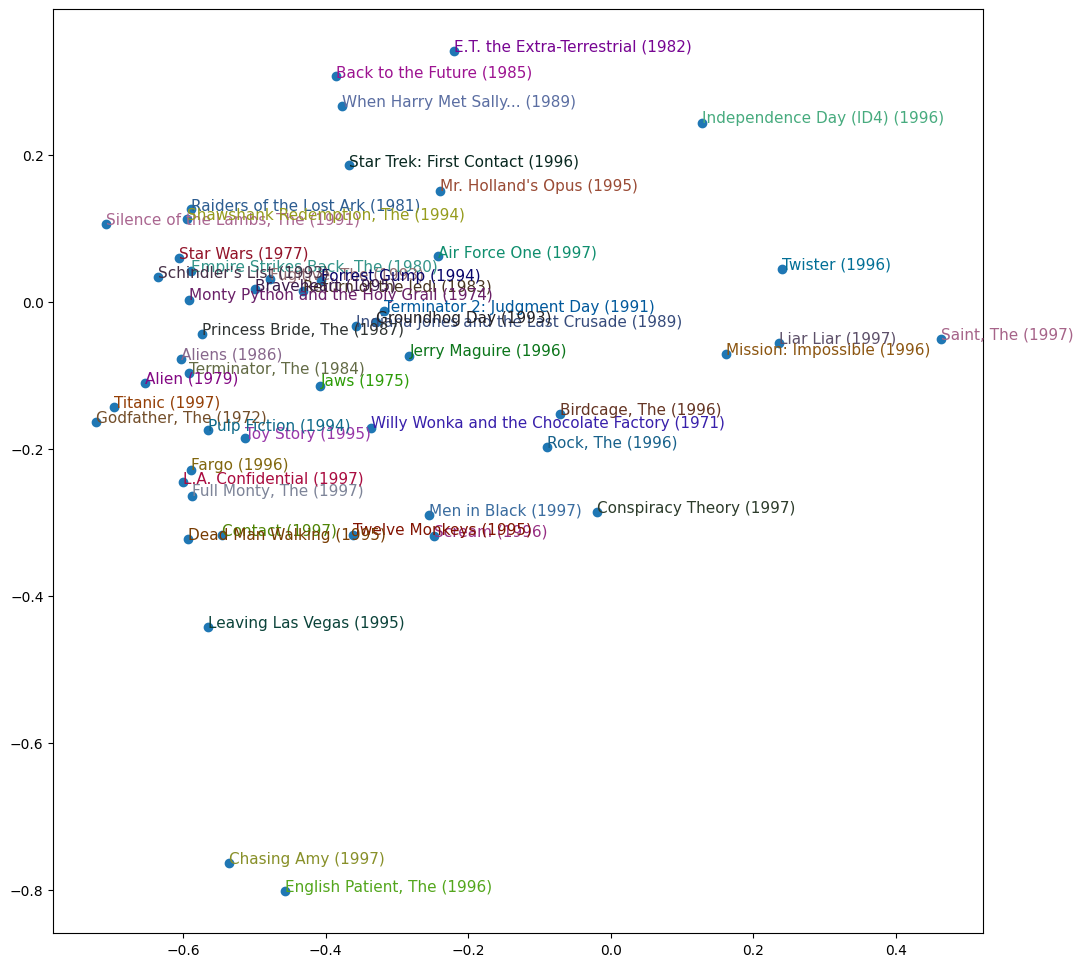

In [53]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([pmf_learner.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = pmf_learner.model.i_weight.weight[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()